In [1]:
# Importing all the necessary packages
import pandas as pd
import numpy as np
import nltk
import string
import re
import gensim
import random

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words as nltk_words


import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore

from multiprocessing import cpu_count

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

c:\Users\laris\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [145]:
%pip install pandas==1.5.3 #needed for the plotting of LDA
%pip install pyLDAvis
%pip install pyLDAvis.gensim

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#needed'


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [76]:
# please change the file path accordingly to your needs

df_w=pd.read_csv('C:/Users/laris/Downloads/western_analysts_tweets.csv/western_analysts_tweets.csv', encoding='latin1') #IMPORTANT - THIS FILE HAS LATIN1 ENCODING

df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16727 entries, 0 to 16726
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16727 non-null  float64
 1   conversation_id  16727 non-null  float64
 2   created_at       16727 non-null  object 
 3   date             16727 non-null  object 
 4   time             16727 non-null  object 
 5   timezone         16727 non-null  int64  
 6   user_id          16727 non-null  float64
 7   username         16727 non-null  object 
 8   name             16727 non-null  object 
 9   place            531 non-null    object 
 10  tweet            16727 non-null  object 
 11  language         16727 non-null  object 
 12  mentions         16727 non-null  object 
 13  urls             16727 non-null  object 
 14  photos           16727 non-null  object 
 15  replies_count    16727 non-null  int64  
 16  retweets_count   16727 non-null  int64  
 17  likes_count 

In [77]:
df_r=pd.read_csv("C:/Users/laris/Downloads/russian_propaganda_tweets.csv/russian_propaganda_tweets.csv" ,encoding='latin1') #IMPORTANT - THIS FILE HAS LATIN1 ENCODING
#some of the columns were causing issues so they were already removed in the csv file
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22602 entries, 0 to 22601
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               22602 non-null  float64
 1   conversation_id  22602 non-null  float64
 2   created_at       22602 non-null  object 
 3   date             22602 non-null  object 
 4   time             22602 non-null  object 
 5   tweet            22602 non-null  object 
 6   tweet.1          22602 non-null  object 
 7   retweets_count   22602 non-null  int64  
 8   likes_count      22602 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 1.6+ MB


We can see that for Russian dataset we have a bit more values (22602 compared to 16727 for the Western dataset). So there is a slight imbalance, which might impact the result from the classifier later on.

In [78]:
#Keeping only the important columns (likes_count and retweets_count used only for sentiment analysis later on)
columns_to_keep = ['created_at', 'tweet', 'likes_count','retweets_count']
df_w = df_w[columns_to_keep]
df_r = df_r[columns_to_keep]

df_w.head()

created_at  \
0  2022-02-24 02:01:32 GTB Standard Time   
1  2022-02-24 02:02:33 GTB Standard Time   
2  2022-02-24 02:03:39 GTB Standard Time   
3  2022-02-24 02:15:19 GTB Standard Time   
4  2022-02-24 02:19:59 GTB Standard Time   

                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  
0              40  
1              28  
2              17  
3             123  
4             180

In [79]:
df_r.head()

created_at  \
0  2022-02-24 14:01:58 GTB Standard Time   
1  2022-02-24 14:24:32 GTB Standard Time   
2  2022-02-24 14:42:53 GTB Standard Time   
3  2022-02-24 14:50:06 GTB Standard Time   
4  2022-02-24 14:56:54 GTB Standard Time   

                                               tweet  likes_count  \
0                            https://t.co/4dVHUFQVd4           58   
1  ?? President Vladimir Putin: We have to take b...         1243   
2  ?? Vladimir Putin: Over the past 30 years we h...         2881   
3  President #Putin: For 8 years Russia has been ...          904   
4  ?? Vladimir Putin: A veritable empire of lies...         2016   

   retweets_count  
0               5  
1             315  
2             946  
3             281  
4             668

In [80]:
#Adding additional column representing whether the post is from Russian perspective or not (0 for western persepective, 1 for Russian)
df_w = df_w.assign(Label=0)
df_r = df_r.assign(Label=1)

In [81]:
# From the date column, keep only the date info, and create a new column which keeps only the month info

df_w['date'] = df_w['created_at'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group())
df_r['date'] = df_r['created_at'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group())

df_w['month'] = pd.to_datetime(df_w['date'])
df_w['month'] = df_w['month'].dt.month

df_r['month'] = pd.to_datetime(df_r['date'])
df_r['month'] = df_r['month'].dt.month

print(df_w.head())

                              created_at  \
0  2022-02-24 02:01:32 GTB Standard Time   
1  2022-02-24 02:02:33 GTB Standard Time   
2  2022-02-24 02:03:39 GTB Standard Time   
3  2022-02-24 02:15:19 GTB Standard Time   
4  2022-02-24 02:19:59 GTB Standard Time   

                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  
0              40      0  2022-02-24      2  
1              28      0  2022-02-24      2  
2              17      0  2022-02-24      2  
3             123      0  2022-02-24      2  
4             180      0  2022-02-24      2  


In [82]:
df_r.drop('created_at',axis=1,inplace=True) #this column is no longer needed
df_r.head()

tweet  likes_count  \
0                            https://t.co/4dVHUFQVd4           58   
1  ?? President Vladimir Putin: We have to take b...         1243   
2  ?? Vladimir Putin: Over the past 30 years we h...         2881   
3  President #Putin: For 8 years Russia has been ...          904   
4  ?? Vladimir Putin: A veritable empire of lies...         2016   

   retweets_count  Label        date  month  
0               5      1  2022-02-24      2  
1             315      1  2022-02-24      2  
2             946      1  2022-02-24      2  
3             281      1  2022-02-24      2  
4             668      1  2022-02-24      2

In [83]:
df_w.drop('created_at',axis=1, inplace=True) #this column is no longer needed
df_w.head()

tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  
0              40      0  2022-02-24      2  
1              28      0  2022-02-24      2  
2              17      0  2022-02-24      2  
3             123      0  2022-02-24      2  
4             180      0  2022-02-24      2

In [84]:
print(df_r.value_counts('month'))
print(df_w.value_counts('month'))

month
4    9722
3    8960
5    2308
2    1612
Name: count, dtype: int64
month
3    7501
4    6179
2    1780
5    1267
Name: count, dtype: int64


With the dates, we can again see there will be some imbalance, as the majority of the tweets are in months 3 and 4, March and April.

In [85]:
#Checking for missing values
print(df_w.isnull().sum())
print(df_r.isnull().sum())

# No missing values in the datasets

tweet             0
likes_count       0
retweets_count    0
Label             0
date              0
month             0
dtype: int64
tweet             0
likes_count       0
retweets_count    0
Label             0
date              0
month             0
dtype: int64


In [92]:
#Checking for the duplicates, but we are keeping the first values as we dont want to remove these

duplicates_count_r = df_r.duplicated(keep='first')
print(duplicates_count_r.sum())

df_r.drop_duplicates(keep='first', inplace=True)


5


In [93]:
duplicates_count_w = df_w.duplicated(keep='first')
print(duplicates_count_w.sum())

df_w.drop_duplicates(keep='first', inplace=True)


5


In [94]:
#Preprocess and clean the tweets column

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    custom_stopwords = {
    "war", "via", "http", "https", "www", "com", "bit", "ly", "amp", 'another',
    "get", "like", "just", "say", "says", "said", "will", "new", "now", "today", 'make', 'made',
    'russian','russia','ukraine','ukrainian',
    'would', 'will', 'exactly', 'know','going','like','thing', 
}

    def clean_text(text):
        # Remove URLs
        text = re.sub(r"https?://\S+", "", text)
        # Remove non-alphanumeric characters and extra whitespaces
        text = re.sub(r"[^a-zA-Z\s']", " ", text)
        # Remove extra whitespaces
        text = re.sub(r"\s+", " ", text)
        # Remove hashtags (words starting with #)
        text = re.sub(r"#\w+", "", text)
        # Remove mentions (words starting with @)
        text = re.sub(r"@\w+", "", text)
        # Remove punctuation and special characters (excluding apostrophes)
        text = re.sub(r"[^\w\s']", "", text)
        # Remove newline characters
        text = re.sub(r"[\n\r]", " ", text)
        # Convert to lowercase
        text = text.lower()
        return text

    cleaned_text = clean_text(text)

    tokens = word_tokenize(cleaned_text)

    # Additionally remove stopwords, punctuation, custom stopwords, and lemmatize
    new_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w not in punctuation and w not in custom_stopwords and len(w) > 3]

    return (new_tokens)

cleaned_tokens_w = df_w['tweet'].apply(preprocess_text)
cleaned_tokens_r = df_r['tweet'].apply(preprocess_text)

print(cleaned_tokens_w.head(10))
print(cleaned_tokens_r.head(10))

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x000001BEB36F3740>
Traceback (most recent call last):
  File "c:\Users\laris\anaconda3\Lib\site-packages\nltk\data.py", line 1160, in __del__
    if not self.closed:
           ^^^^^^^^^^^
  File "c:\Users\laris\anaconda3\Lib\site-packages\nltk\data.py", line 1180, in closed
    return self.stream.closed
           ^^^^^^^^^^^
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


0    [security, council, hold, emergency, session, ...
1                           [kyiv, time, urgent, year]
2               [rare, meeting, unsc, time, requested]
3    [turkish, force, airbus, entered, airspace, lo...
4    [cyber, attack, targeting, website, security, ...
5    [secretary, state, blinken, belief, invade, ni...
6      [clash, audible, night, mariupol, herooftheday]
7    [blinken, doubling, security, diplomatic, huma...
8    [landed, czech, republic, practicing, quick, t...
9    [israeli, civilian, aircraft, flying, western,...
Name: tweet, dtype: object
0                                                   []
1    [president, vladimir, putin, take, bold, immed...
2    [vladimir, putin, past, year, patiently, tryin...
3    [president, putin, year, everything, possible,...
4    [vladimir, putin, veritable, empire, lie, crea...
5                            [asbmilitary, good, luck]
6    [president, putin, asked, help, decision, carr...
7    [border, guard, crossed, bryansk,

In [95]:
#Appending these cleaned tokens back to the dataframe

df_w['cleaned_tokens'] = df_w['tweet'].apply(preprocess_text)
df_r['cleaned_tokens'] = df_r['tweet'].apply(preprocess_text)

# Create BOW representations of words for both datasets

In [96]:
# Create a Dictionary object which is mapping unique word tokens to unique IDs
dictionary_w = corpora.Dictionary(cleaned_tokens_w)
print(len(dictionary_w.values()))

dictionary_r = corpora.Dictionary(cleaned_tokens_r)
print(len(dictionary_r.values()))

16807
23742


In [97]:
#Filter out those words tokens that appear in less than 25 documents and more than half of the documents

dictionary_w.filter_extremes(no_below=25, no_above=0.5)
print(len(dictionary_w.iteritems()))

dictionary_r.filter_extremes(no_below=25, no_above=0.5)
print(len(dictionary_r.iteritems()))

1303
1483


In [98]:
# Convert the list with tokenized tweets to BOW representation based on the created dictionary

bow_corpus_w = [dictionary_w.doc2bow(tokens) for tokens in cleaned_tokens_w]
bow_corpus_r = [dictionary_r.doc2bow(tokens) for tokens in cleaned_tokens_r]

In [99]:
#Preview some of the BOW representations to get the idea of the format

for i in range(5):
    print("Document {}: {}".format(i+1, bow_corpus_w[i]))

for i in range(5):
    print("Document {}: {}".format(i+1, bow_corpus_r[i]))

Document 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
Document 2: [(6, 1), (7, 1), (8, 1)]
Document 3: [(7, 1), (9, 1), (10, 1)]
Document 4: [(6, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]
Document 5: [(5, 1), (18, 1), (19, 1), (20, 1), (21, 1)]
Document 1: []
Document 2: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
Document 3: [(11, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
Document 4: [(5, 1), (9, 1), (10, 1), (11, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]
Document 5: [(11, 1), (15, 1), (21, 1), (29, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]


In [101]:
#Append the BOW into separate col in our dataframes

bow_scores_w = [dict(doc) for doc in bow_corpus_w]
bow_scores_r = [dict(doc) for doc in bow_corpus_r]

df_w['bow_scores'] = bow_scores_w
df_r['bow_scores'] = bow_scores_r

# Create TF IDF representation from the BOW corpus


In [102]:
#setting seed for reproducibility

np.random.seed(42)
random.seed(42)

In [103]:
#TF IDF is a more accurate and precise representation than BOW

tfidf_w = models.TfidfModel(bow_corpus_w)
tfidf_r = models.TfidfModel(bow_corpus_r)

In [104]:
corpus_tfidf_w = tfidf_w[bow_corpus_w]
corpus_tfidf_r = tfidf_r[bow_corpus_r]

In [105]:
# Convert the TF-IDF representations into a list of dictionaries where each dictionary represents TF-IDF scores for a document
tfidf_scores_w = [dict(corpus_tfidf_w[i]) for i in range(len(corpus_tfidf_w))]
tfidf_scores_r = [dict(corpus_tfidf_r[i]) for i in range(len(corpus_tfidf_r))]

# Append the TF-IDF scores as a separate column in the DataFrame
df_w['tfidf_scores'] = tfidf_scores_w
df_r['tfidf_scores'] = tfidf_scores_r


print(df_w.head())
print(df_r.head())


                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  \
0              40      0  2022-02-24      2   
1              28      0  2022-02-24      2   
2              17      0  2022-02-24      2   
3             123      0  2022-02-24      2   
4             180      0  2022-02-24      2   

                                      cleaned_tokens  \
0  [security, council, hold, emergency, session, ...   
1                         [kyiv, time, urgent, year]   
2             [rare, meeting, unsc, time, requested]   
3  [turkish, force, airbus, entered, airspace, lo...   
4  [cyber, attack, tar

# Saving the cleaned datasets, used for other tasks in the project




In [108]:
#Save this dataframe view as new csv for easier reuse
#Note that this saves the df into the session in colab - you need to download the csv for reusal

df_w.to_csv('df_w.csv', index=False)
df_r.to_csv('df_r.csv', index=False)

In [110]:
# Also produce a merged dataframe of the both
merged_df = pd.concat([df_w, df_r], ignore_index=True)

print(merged_df.info())

merged_df.to_csv('merged_df.csv', index=False)

#with dropping the rows and changing columns, we now have 39319 rows and 9 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39319 entries, 0 to 39318
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet           39319 non-null  object
 1   likes_count     39319 non-null  int64 
 2   retweets_count  39319 non-null  int64 
 3   Label           39319 non-null  int64 
 4   date            39319 non-null  object
 5   month           39319 non-null  int32 
 6   cleaned_tokens  39319 non-null  object
 7   bow_scores      39319 non-null  object
 8   tfidf_scores    39319 non-null  object
dtypes: int32(1), int64(3), object(5)
memory usage: 2.5+ MB
None


# Run LDA model with TF IDF (I also tried with BOW, not that much difference)

In [111]:


# Define hyperparameter search space
hyperparameters = {
    'num_topics': [1,2,3,4,5,6,7,8,9,10],
    'chunksize': [100, 200, 300],
    'passes': [5, 10, 15],
    'iterations': [50, 100,150, 200],
    'alpha': [random.uniform(0.1, 1.0), random.uniform(0.01, 0.5)],
    'eta': [random.uniform(0.1, 1.0), 'auto'],
    'random_state': [42]
}

def train_lda_model(corpus, dictionary, cleaned_tokens):
    best_model = None
    best_coherence = float('-inf')
    best_hyperparameters = {}

    num_trials = 10
    for _ in range(num_trials):
        # Randomly sample hyperparameters
        sampled_hyperparameters = {param: random.choice(values) for param, values in hyperparameters.items()}

        # Train LDA model with sampled hyperparameters
        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, workers=3, **sampled_hyperparameters)

        # Calculate coherence score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_tokens, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model_lda.get_coherence()

        # Update best model if necessary
        if coherence > best_coherence:
            best_model = lda_model
            best_coherence = coherence
            best_hyperparameters = sampled_hyperparameters

    return best_model, best_coherence, best_hyperparameters

# Hyperparameter tuning for df_w
best_model_w, best_coherence_w, best_hyperparameters_w = train_lda_model(corpus_tfidf_w, dictionary_w, cleaned_tokens_w)
print("Best Model Topics (dataset_w):", best_model_w.show_topics())
print("Best Model Coherence Score (dataset_w):", best_coherence_w)
print("Best Model Hyperparameters (dataset_w):", best_hyperparameters_w)

# Hyperparameter tuning for df_r
best_model_r, best_coherence_r, best_hyperparameters_r = train_lda_model(corpus_tfidf_r, dictionary_r, cleaned_tokens_r)
print("Best Model Topics (dataset_r):", best_model_r.show_topics())
print("Best Model Coherence Score (dataset_r):", best_coherence_r)
print("Best Model Hyperparameters (dataset_r):", best_hyperparameters_r)


Best Model Topics (dataset_w): [(0, '0.011*"people" + 0.010*"mariupol" + 0.009*"azovstal" + 0.007*"year" + 0.007*"civilian" + 0.007*"belarusian" + 0.006*"moskva" + 0.006*"child" + 0.006*"plant" + 0.006*"ship"'), (1, '0.033*"missile" + 0.021*"region" + 0.021*"airfield" + 0.020*"helicopter" + 0.019*"aircraft" + 0.018*"flying" + 0.017*"explosion" + 0.017*"cruise" + 0.016*"launch" + 0.015*"time"'), (2, '0.028*"truck" + 0.025*"moving" + 0.022*"vehicle" + 0.021*"towards" + 0.021*"station" + 0.020*"highway" + 0.019*"train" + 0.018*"railway" + 0.017*"gomel" + 0.017*"equipment"'), (3, '0.011*"president" + 0.009*"zelensky" + 0.009*"minister" + 0.008*"putin" + 0.008*"sanction" + 0.008*"country" + 0.007*"state" + 0.006*"defense" + 0.006*"foreign" + 0.006*"weapon"'), (4, '0.013*"force" + 0.008*"think" + 0.008*"update" + 0.007*"offensive" + 0.006*"likely" + 0.006*"donbas" + 0.006*"still" + 0.006*"operation" + 0.005*"much" + 0.005*"good"'), (5, '0.020*"oblast" + 0.018*"destroyed" + 0.015*"tank" + 0.0

In [116]:
#We are setting the num_topics, alpha and beta to values found through hyperparameter tuning

lda_model_w = gensim.models.LdaMulticore(corpus_tfidf_w, num_topics=5,
                                         id2word=dictionary_w, 
                                         alpha='asymmetric',  
                                         eta='symmetric',
                                         chunksize= 100, 
                                         passes= 15, 
                                         iterations= 150,
                                         random_state=42)     

In [118]:
lda_model_r = gensim.models.LdaMulticore(corpus_tfidf_r, num_topics=4,
                                         id2word=dictionary_r, 
                                         alpha='asymmetric',  
                                         eta='symmetric',
                                         chunksize=100,
                                         passes= 15, 
                                         iterations= 150,
                                         random_state=42                                    
                                         )     


In [117]:
# Calculate coherence score for the Western LDA model
coherence_model_w = CoherenceModel(model=lda_model_w, texts=cleaned_tokens_w, dictionary=dictionary_w, coherence='c_v')
coherence_score_w = coherence_model_w.get_coherence()
print("Coherence Score for Western LDA model:", coherence_score_w)

Coherence Score for Western LDA model: 0.4826745395339419


In [492]:
# Calculate coherence score for the Russian LDA model
coherence_model_r = CoherenceModel(model=lda_model_r, texts=cleaned_tokens_r, dictionary=dictionary_r, coherence='c_v')
coherence_score_r = coherence_model_r.get_coherence()
print("Coherence Score for Russian LDA model:", coherence_score_r)

Coherence Score for Russian LDA model: 0.49715961286924354


In [119]:
for idx, topic in lda_model_w.print_topics(-1): # -1 corresponds to all topics
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"force" + 0.007*"video" + 0.006*"destroyed" + 0.006*"oblast" + 0.006*"kyiv" + 0.006*"vehicle" + 0.006*"tank" + 0.006*"military" + 0.005*"missile" + 0.005*"kharkiv"
Topic: 1 
Words: 0.039*"think" + 0.028*"footage" + 0.023*"orlan" + 0.023*"thanks" + 0.022*"sure" + 0.021*"work" + 0.017*"read" + 0.016*"thread" + 0.015*"though" + 0.015*"interesting"
Topic: 2 
Words: 0.115*"april" + 0.066*"bucha" + 0.045*"moskva" + 0.037*"site" + 0.032*"return" + 0.031*"website" + 0.028*"northern" + 0.026*"shot" + 0.026*"chechen" + 0.023*"popasna"
Topic: 3 
Words: 0.046*"found" + 0.043*"route" + 0.039*"thestudyofwar" + 0.035*"howitzer" + 0.030*"radar" + 0.030*"criticalthreats" + 0.025*"mortar" + 0.025*"liberated" + 0.024*"unlikely" + 0.023*"terrain"
Topic: 4 
Words: 0.073*"change" + 0.057*"steel" + 0.053*"began" + 0.042*"admiral" + 0.033*"azovstal" + 0.032*"blue" + 0.029*"camp" + 0.027*"onto" + 0.025*"price" + 0.025*"update"


In [120]:
for idx, topic in lda_model_r.print_topics(-1): # -1 corresponds to all topics
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.007*"people" + 0.005*"force" + 0.005*"military" + 0.004*"mariupol" + 0.004*"kiev" + 0.004*"year" + 0.004*"time" + 0.004*"nato" + 0.004*"country" + 0.004*"want"
Topic: 1 
Words: 0.041*"geromanat" + 0.037*"good" + 0.026*"think" + 0.024*"yeah" + 0.021*"nazi" + 0.021*"never" + 0.018*"armchairw" + 0.018*"much" + 0.018*"right" + 0.016*"shit"
Topic: 2 
Words: 0.048*"stalinfrog" + 0.037*"april" + 0.033*"pelmenipusha" + 0.027*"cpimentel" + 0.023*"sent" + 0.021*"already" + 0.018*"denyo" + 0.018*"imohar" + 0.018*"french" + 0.017*"map"
Topic: 3 
Words: 0.059*"levi" + 0.057*"godman" + 0.050*"azovstal" + 0.020*"hahaha" + 0.020*"progress" + 0.016*"moldova" + 0.016*"iwanttospyonyou" + 0.015*"alex" + 0.015*"tochka" + 0.014*"import"


In [121]:
%matplotlib inline

vis = gensimvis.prepare(lda_model_w, corpus_tfidf_w, dictionary_w)
pyLDAvis.display(vis)

C:\Users\laris\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\laris\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [122]:
%matplotlib inline

vis = gensimvis.prepare(lda_model_r, corpus_tfidf_r, dictionary_r)
pyLDAvis.display(vis)

C:\Users\laris\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


# Word Clouds (Larissa will adjust this a bit later)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


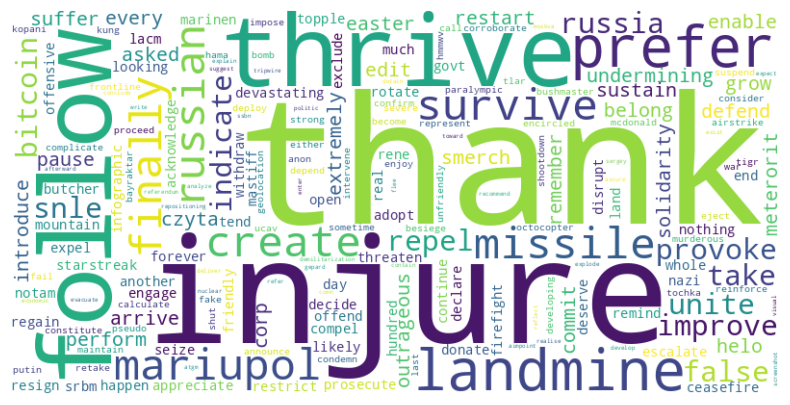

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter
import itertools


# Calculate document frequency of each word
# Flatten the list of lists into a single list
tokens_flat_w = list(itertools.chain.from_iterable(cleaned_tokens_w))

# Calculate document frequency of each word
word_document_freq = Counter(tokens_flat_w)

# Filter words based on document frequency
filtered_tokens = [token for token in set(tokens_flat_w)
                   if word_document_freq[token] / len(cleaned_tokens_w) <= 0.5]

# Concatenate filtered tokens into a single string
text_w = ' '.join(filtered_tokens)


# Generate word cloud
#all_tokens = [token for tokens in cleaned_tokens_w for token in tokens]
#text_w = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_w)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


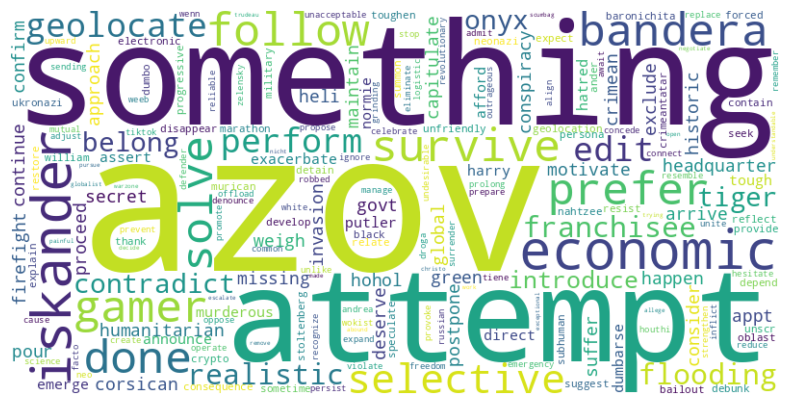

In [ ]:
# Calculate document frequency of each word
# Flatten the list of lists into a single list
tokens_flat_r = list(itertools.chain.from_iterable(cleaned_tokens_r))

# Calculate document frequency of each word
word_document_freq = Counter(tokens_flat_r)

# Filter words based on document frequency
filtered_tokens = [token for token in set(tokens_flat_r)
                   if word_document_freq[token] / len(cleaned_tokens_r) <= 0.5]

# Concatenate filtered tokens into a single string
text_r = ' '.join(filtered_tokens)


# Generate word cloud
#all_tokens = [token for tokens in cleaned_tokens_w for token in tokens]
#text_w = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_r)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()
